# My TTN library
In this notebook I try to develop my personal library to handle TTNs, their definition, properties, automatic contraction and training.

In [2]:
import torch
import numpy as np
from typing import Sequence, List, Tuple, ValuesView
import graphviz
from matplotlib import colormaps, colors
import matplotlib.pyplot as plt
import colorsys
from tqdm import tqdm, trange
from string import ascii_letters
from timeit import timeit
from datetime import datetime
from algebra import contract_up, sep_partial_dm
from utils import adjust_lightness, get_mnist_data_loaders, accuracy

/media/alberto/Volume/Kubuntu/PoD/Thesis/TN4HEP/TTN/algebra.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Automatic contractions
Try to develop methods to do automatic contractions, also based on the network structure (separability of states)
### Network description

In [3]:
from __future__ import annotations
from collections import UserString

class TIndex:
    def __init__(self, name, inds: Sequence[str] | np.ndarray):
        self.__name = name
        self.__tindices = np.array(inds, dtype=np.str_) # problems with string lenghts
        self.__ndims = len(inds)
    
    def __getitem__(self, key: int) -> str:
        return self.__tindices[key]
    
    def __setitem__(self, key: int, value: str):
        old_len = self.__tindices.dtype.itemsize / 4
        new_len = max(old_len, len(value))
        self.__tindices = self.__tindices.astype(f"<U{new_len:.0f}")
        self.__tindices[key] = value
    
    @property
    def name(self):
        return self.__name 

    @property
    def indices(self):
        return self.__tindices
    
    @property
    def ndims(self):
        return self.__ndims
    
    ''' I do not want them to be changed by design   
    @indices.setter
    def indices(self, value: Sequence[str]):
        self.__indices = value
    '''
    
    def __eq__(self, __value: TIndex | str) -> bool:
        if isinstance(__value, str):
            return self.__name == __value
        return self.__name == __value.name and np.all(self.__tindices == __value.indices)
    
    def __gt__(self, __value: TIndex | str) -> bool:
        compare = __value if isinstance(__value, str) else __value.name
        try:    compare_layer = int(compare.split('.')[0])
        except: compare_layer = np.inf
        try:    self_layer = int(self.__name.split('.')[0])
        except: self_layer = np.inf

        if self_layer > compare_layer:
            return True
        elif self_layer == compare_layer:
            return int(self.__name.split('.')[1]) > int(compare.split('.')[1])
        return False
    
    def __lt__(self, __value: TIndex | str) -> bool:
        compare = __value if isinstance(__value, str) else __value.name
        try:    compare_layer = int(compare.split('.')[0])
        except: compare_layer = np.inf
        try:    self_layer = int(self.__name.split('.')[0])
        except: self_layer = np.inf

        if self_layer < compare_layer:
            return True
        elif self_layer == compare_layer:
            return int(self.__name.split('.')[1]) < int(compare.split('.')[1])
        return False
    
    def __ge__(self, __value: TIndex | str) -> bool:
        return self.__gt__(__value) or self.__eq__(__value)
    
    def __le__(self, __value: TIndex | str) -> bool:
        return self.__lt__(__value) or self.__eq__(__value)
    
    def __hash__(self):
        return hash(self.__name)
    
    def __str__(self) -> str:
        return self.__name
    
    def __repr__(self) -> str:
        return 'TIndex: ' + self.__name
    
    def _repr_markdown_(self):
        return f'**{self.__repr__()}**'
    
    def _repr_html_(self):
        markdown_str = f'<details><summary><b style="color:#0088d9; font-size:100%; font-family: verdana, sans-serif">{self.__repr__()} </b></summary>'
        for index in self.__tindices:
            markdown_str += f'&emsp;&ensp; <b style="color:#be00d9">{index}</b><br>'
        return markdown_str + '</details>'
    
class TTNIndex(TIndex):
    def __init__(self, layer: int, layer_index: int):

        self.__layer = layer
        self.__layer_index = layer_index
        super(TTNIndex, self).__init__(f"{layer}.{layer_index}",
                                       [f"{layer+1}.{2*layer_index}", f"{layer+1}.{2*layer_index+1}", f"{layer}.{layer_index}"], 
                                       )
    
    def __repr__(self) -> str:
        return f"TTNIndex: {self.__layer}.{self.__layer_index}"
    
# class which represent the link between two tensors in the TTN
class TLink:
    def __init__(self, source: TIndex, target: TIndex, dim: int, dependencies: List[TIndex] = [], name: str = None):
        self.__source = source
        self.__target = target
        self.__dim = dim
        self.__vector = None
        self.__has_updated_vector = False
        self.__name = name if name is not None else f"{source.name}"
        self.__dependencies = dependencies

    @property
    def source(self):
        return self.__source
    
    @property
    def target(self):
        return self.__target
    
    @property
    def name(self):
        return self.__name
    
    @property
    def vector(self):
        if self.__has_updated_vector:
            return self.__vector
        elif self.__vector is not None:
            raise ValueError(f"No vector is set for TLink {self.__name}.")
        else:
            raise ValueError(f"TLink {self.__name} vector is not updated.")
        
    @vector.setter
    def vector(self, value):
        self.__vector = value
        self.__has_updated_vector = True

    @property
    def is_updated(self):
        return self.__has_updated_vector
    
    def depends_on(self, __value: TIndex | str) -> bool:
        return __value in self.__dependencies

    


In [25]:
class TTN:
    def __init__(
        self,
        n_features,
        n_phys=2,
        n_labels=2,
        label_tag="label",
        bond_dim=4,
        dtype=torch.cdouble,
        device="cpu",
    ):
        if (n_features % 2) != 0:
            raise ValueError(f"n_features must be  power of 2, got: {n_features}")

        self.n_features = n_features
        self.n_phys     = n_phys
        self.n_labels   = n_labels
        self.label_tag  = label_tag
        self.bond_dim   = bond_dim
        self.device     = device

        self.__dtype    = dtype
        self.__n_layers = int(np.log2(n_features))
        self.__tensors  = []
        self.__indices  = [TTNIndex(l, i) for l in range(self.__n_layers) for i in range(2**l)]
        # label top edge as label
        self.__indices[0][2] = label_tag
        # label bottom edges as data
        for ttnindex in self.__indices[-2**(self.__n_layers-1):]:
            ttnindex[0] = f'data.{ttnindex[0].split(".")[1]}'
            ttnindex[1] = f'data.{ttnindex[1].split(".")[1]}'
        # convert to numpy array for easier indexing
        self.__indices = np.asarray(self.__indices)

        self.__initialized = False

        ## INITIALIZE TENSORS ##
        '''self.__id = np.zeros([self.bond_dim] * 3, dtype=np.float64)
        for i in range(self.__id.shape[0]):
            self.__id[i, i, i] = 1.0'''

        # add first tensor with special index
        if not (self.__n_layers - 1):
            self.__tensors.append(
                torch.rand(
                    size=(self.n_phys, self.n_phys, self.n_labels),
                    dtype=self.__dtype,
                    device=self.device
                )
            )
        else:
            dim = min(self.n_phys**2**(self.__n_layers-1), self.bond_dim)
            self.__tensors.append(
                torch.rand(
                    size=(dim, dim, self.n_labels),
                    dtype=self.__dtype,
                    device=self.device
                )
            )

        for l in range(1, self.__n_layers - 1):  # constructing the ttn starting from the top
            dim_pre = min(self.n_phys**2**(self.__n_layers - l - 1), self.bond_dim)
            dim_post = min(self.n_phys **2** (self.__n_layers - l ), self.bond_dim)
            self.__tensors.extend(
                [
                    torch.rand(
                        size=[dim_pre] * 2 + [dim_post],
                        dtype=self.__dtype,
                        device=self.device
                    )
                    if np.random.rand() < 0.5
                    else torch.eye(
                        dim_pre**2, 
                        dtype=self.__dtype,
                        device=self.device)
                        .reshape(dim_pre, dim_pre, -1)[:, :, :dim_post]
                    for i in range(2**l)
                ]
            )

        dim = min(self.n_phys**2, self.bond_dim)
        self.__tensors.extend(
            [
                torch.rand(
                    size=[self.n_phys] * 2 + [dim],
                    dtype=self.__dtype,
                    device=self.device
                )
                for i in range(2 ** (self.__n_layers - 1))
            ]
        )
        ########################
        self.__tensor_map = dict(zip(self.__indices, self.__tensors))
    
    def __getitem__(self, key: Sequence[TTNIndex | str] | str | int | slice) -> dict[TTNIndex, torch.Tensor]:

        if isinstance(key, int):
            return {self.__indices[key]: self.__tensor_map[self.__indices[key]]}
        elif isinstance(key, str):
            return {self.__indices[self.__indices==key].item(): self.__tensor_map[key]}
        elif isinstance(key, Sequence):
            return {k if isinstance(k, TTNIndex) else self.__indices[self.__indices==k].item(): self.__tensor_map[k] for k in key}
        elif isinstance(key, slice):
            return {k: self.__tensor_map[k] for k in self.__indices[key]}
        else:
            raise TypeError(f"Invalid argument type: {type(key)}")
        
    @property
    def indices(self):
        return self.__indices
    
    @property
    def tensors(self):
        return self.__tensors
    
    @tensors.setter
    def tensors(self, value: Sequence[torch.Tensor] | torch.nn.ParameterList):
        self.__tensor_map = dict(zip(self.__indices, value))    # had to put this line before because the setter stops the execution of the rest of the function
        self.__tensors = value
        
    
    @property
    def n_layers(self):
        return self.__n_layers
    
    @property
    def initialized(self):
        return self.__initialized
        
    def __repr__(self) -> str:
        return f"TTN"
    
    def _repr_html_(self):
        markdown_str = f'<details><summary><b style="color:#d95100; font-size:100%; font-family: verdana, sans-serif">{self.__repr__()} </b></summary>'
        for tindex in self.__indices:
            markdown_str += f'{tindex._repr_html_()}'
        return markdown_str + '</details>'
    
    def get_branch(self, tindex: TTNIndex | str, till: str='data') -> dict[TTNIndex, torch.Tensor]:
        """
        Returns a dictionary of tensors and indices of the branch starting at tindex, going down to the bottom of the TTN.
        """
        if isinstance(tindex, str):
            tindex = self.__indices[self.__indices==tindex].item()
        branch_indices = [tindex]
        branch_layer   = [tindex]
        while till not in branch_layer[0][0]:
            branch_layer = [self.__indices[self.__indices==tindex[i]].item() for tindex in branch_layer for i in range(tindex.ndims-1)] 
            branch_indices.extend(branch_layer) 

        return self.__getitem__(branch_indices)
    
    def get_layer(self, layer: int) -> dict[TTNIndex, torch.Tensor]:
        """
        Returns a dictionary of tensors and indices of the layer layer.
        """
        return {tindex: self.__tensor_map[tindex] for tindex in self.__indices if int(tindex.name.split('.')[0]) == layer}
    
    
    def _propagate_data_through_branch_(self, data: dict[TIndex, torch.Tensor], branch: dict[TTNIndex, torch.Tensor], keep=False, pbar=None) -> dict[TIndex, torch.Tensor] :
        """
        Propagates data through a branch of the TTN.
        """

        sorted_branch_keys = sorted(branch.keys(), reverse=True)
        last_idx = sorted_branch_keys[-1]
        branch_data = data | branch
        for tindex in sorted_branch_keys:
            if pbar is not None:
                pbar.set_postfix_str(f"contracting {tindex.name}")
            branch_data[tindex] = contract_up(branch_data[tindex].contiguous(), [branch_data[tindex[0]], branch_data[tindex[1]]])
            if pbar is not None:
                pbar.update(1)
                pbar.set_postfix_str(f"contracted {tindex.name}")
                

        if not keep:
            result = branch_data[last_idx].clone()
            del branch_data

        return {key: branch_data[key] for key in sorted_branch_keys} if keep else {TIndex(last_idx.name, last_idx[2]): result}

    
    def draw(self, name='TTN', cmap='viridis', fontsize=11):
        cmap = colormaps.get_cmap(cmap)
        categories = np.linspace(0.2, 1, self.__n_layers)
        dot = graphviz.Digraph(name, comment='TTN: ' + name, format='svg', engine='dot', renderer='cairo', graph_attr={'bgcolour': 'transparent', 'rankdir': 'LR', 'splines':'false', 'size':'16,14', 'ratio':'compress', 'fontname':'Arial'})
        dot.attr('node', shape='circle', width='0.35', fixedsize='true', fontsize=str(fontsize))
        dot.attr('edge', color='#bfbfbf', fontsize=str(fontsize-2))
        dot.edge('0.0', 'hide', label=self.label_tag)
        dot.node('hide', '', shape='plaintext')
        for tindex in self.__indices:
            c_rgba = list(cmap(categories[int(tindex.name.split('.')[0])]))

            dot.node(tindex.name, tindex.name, fillcolor=colors.rgb2hex(c_rgba), style='filled', color=colors.rgb2hex(adjust_lightness(c_rgba, amount=0.8)), penwidth='4')
            
            dot.edge(tindex[0], tindex.name, label=tindex[0], weight=str((int(tindex.name.split('.')[0])+1)**2))
            dot.edge(tindex[1], tindex.name, label=tindex[1], weight=str((int(tindex.name.split('.')[0])+1)**2))
        
        for i in range(2**self.__n_layers):
            dot.node(f'data.{i}', '', shape='plaintext', width='0.1', height='0.1')
        return dot
    
    def initialize(self, train_dl: torch.utils.data.DataLoader, loss_fn):
        # now we want to run across the ttn, layer by layer
        # and initialize the tensors by getting the partial dm
        # of two sites of the previous layer, diagonalizing it,
        # and isometrizing the rotation matrix (with n eigenvectors
        # corresponding to the n=bond_dim greatest eigenvalues)
        '''
        data = train_dl
        pbar = tqdm(
            total=(self.n_layers - 1) * len(train_dl)
                  + 2 * (2 ** (self.n_layers - 1) - 1),
            desc="ttn unsupervised init",
            position=1,
            leave=True,
        )
        for layer in range(self.n_layers - 1, 0, -1):  # do this for all layers except the uppermost one
            pbar.set_postfix_str(f"doing layer {layer}")
            next_layer_list = []
            ttn_curr_layer = self.get_layer(layer).items()
            # perform initialization of current layer with partial dm
            # of state at previous layer
            for tindex, tensor in ttn_curr_layer:
                pbar.set_postfix_str(f"doing layer {layer}, tensor {tindex.name.split('.')[1]}/{2**layer}")
                sel_sites = [int(index.split(".")[-1]) for index in tindex.indices[:2]]
                partial_dm = torch.concat(
                    [
                        sep_partial_dm(sel_sites, data_batch, skip_norm=True, device=self.device)
                        for data_batch in data
                    ]
                ).mean(dim=0)
                eigenvectors = torch.linalg.eigh(partial_dm)[1][:, -tensor.shape[-1]:]  
                
                # now we isometrize the tensor with a qr decomposition
                # in the reduced case (m>n) this return Q, R with Q being
                # an isometry with shape m x n and R being an upper triangular matrix n x n
                Q, R = torch.linalg.qr(eigenvectors)

                # the physical indices of the two sites are fused in the first index, we have to reshape
                tensor = Q.reshape(tensor.shape)
                # now we have to update the tensor connected in the next 
                # layer contracting it with R
                upper_index, position = [index for index in self.__indices if tindex.indices[-1] in index.indices][0]
                upper_tensor = self.__tensor_map[]
                upper_tensor = torch.matmul(R, upper_tensor.transpose())


                pbar.update(1)

            # calculate next propagation of data to this layer
            # with the updated tensors
            pbar.set_postfix_str(f"doing layer {layer}, propagating data")
            for data_batch in data:
                new_data_layer = self._propagate_data_through_branch_(data_batch, ttn_curr_layer)
                next_layer_list.append(new_data_layer)

                pbar.update(1)
            del data_tn_batched
            data_tn_batched = next_layer_list
        pbar.set_postfix_str(f'done unsupervised init!')
        pbar.close()
    
        # now we want to initialize the top tensor
        pbar = tqdm(data_tn_batched, total=len(data_tn_batched), desc='ttn supervised init',position=0)
        top_tensor = ttn.select_tensors('l0')[0]
        top_parameter = torch.nn.Parameter(top_tensor.data)
        _ = one_epoch_one_tensor(top_parameter, data_tn_batched, train_dl, torch.optim.Adam([top_parameter]), loss_fn, device=device)
        top_tensor.modify(data=top_parameter.data, inds=top_tensor.inds, tags=top_tensor.tags)
        '''
        self.__initialized = True

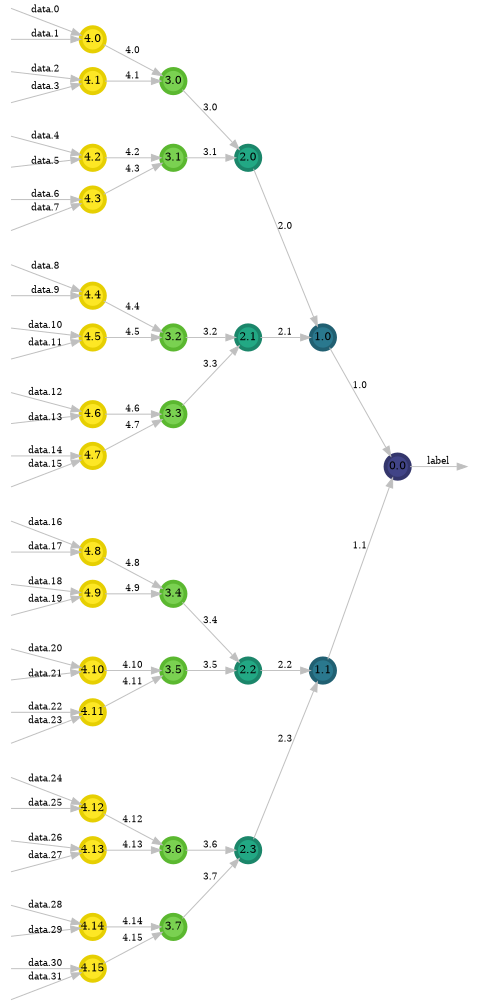

In [35]:
DEVICE = 'cuda'
DTYPE = torch.double
N_FEAT = 32
ttn = TTN(N_FEAT, bond_dim=8, n_labels=4,device=DEVICE, dtype=DTYPE)
ttn.draw()

### Basic operations
General purpose contraction, not optimized

In [7]:
def contract(
        tensors : Sequence[torch.Tensor] | ValuesView[torch.Tensor], 
        tindices: Sequence[TTNIndex | TIndex], 
        keep    : Sequence[str] | None=None, 
        outname : str | None=None
):
    """
    Contract two tensors along the matching TIndices in indices, except for the indices in keep.
    """
    if len(tindices) != len(tensors):
        raise ValueError(f"Expected tensors and tindices to have same lenght, got {len(tensors)} and {len(tindices)}")

    if keep is None:
        keep = []
    elif isinstance(keep, str):
        keep = [keep]
    elif not isinstance(keep, Sequence):
        raise TypeError(f"Expected keep to be None, str or Sequence, got {type(keep)}")

    keep = list(keep)
    unique_inds, counts = np.unique(np.concatenate([tindex.indices for tindex in tindices]), return_counts=True)
    if np.any(np.isin(keep, unique_inds, invert=True)):
        raise ValueError(f"keep contains indices that are not in tindices: {np.asarray(keep)[np.where(np.isin(keep, unique_inds, invert=True))[0]]}")
    if len(unique_inds) > len(ascii_letters):
        raise ValueError(f"Too many indices to contract: {len(unique_inds)} > {len(ascii_letters)}")

    # find output indices (all indices that are not contracted or kept)
    output_inds = unique_inds[np.isin(unique_inds, keep) | (counts == 1)]
    
    # map indices to letters
    idx_to_char_map = {tind: ascii_letters[i] for i, tind in enumerate(unique_inds)}
    
    # contraction strings
    ## tensor indices
    tindices_str = ["..."+"".join([idx_to_char_map[i] for i in tindex.indices]) for tindex in tindices] # the ellipsis is for batch dimension
    ## output indices
    outinds_str = "..."+"".join([idx_to_char_map[i] for i in output_inds])

    #print(tindices_str,'\n' ,outinds_str)
    # contract
    C = torch.einsum(f"{','.join(tindices_str)}->{outinds_str}", *tensors)

    return C, TIndex(f"{min(tindices)}" if outname is None else outname, output_inds)

    

Let's exploit the TTN topology to optimize contractions, i.e. make them go from bottom to top

In [8]:
def contract_up(tensor: torch.Tensor, data_tensors: Sequence[torch.Tensor]):
    # this function is the fundamental block for TTN contractions:
    # it takes a ttn tensor and two data vectors and contracts them to a new vector
    
    left = torch.matmul(data_tensors[0], tensor.view(tensor.shape[0], -1))              # left contraction with data (b x p) @ (p x d) -> (b x d) where d is m*n
    right = torch.bmm(data_tensors[1].unsqueeze(1), left.view(-1, *tensor.shape[1:]))   # right contraction with data (b x 1 x m) @ (b x m x n) -> (b x n) 

    return right.view(-1, tensor.shape[2])

def contract_up_einsum(tensor: torch.Tensor, data_tensors: Sequence[torch.Tensor]):
    # this function is the fundamental block for TTN contractions:
    # it takes a ttn tensor and two data vectors and contracts them to a new vector

    return torch.einsum('bi,ijk,bj->bk', data_tensors[0], tensor, data_tensors[1])

### Tests

In [10]:
data = torch.rand(32, 10, 2, dtype=DTYPE, device=DEVICE).unbind(0)
data_indices = [TIndex(f"{ttn.n_layers}.{i}", [f"data.{i}"]) for i in range(32)]

time1 = timeit(lambda: contract_up(ttn.tensors[-1], data[:2]), number=10000)
time2 = timeit(lambda: contract((ttn.tensors[-1],) + data[:2], [ttn.indices[-1]]+data_indices[:2]), number=10000)
time3 = timeit(lambda: contract_up_einsum(ttn.tensors[-1], data[:2]), number=10000)
time1, time2, time3

(0.47830858999998327, 4.161032801000033, 2.252023615999974)

In [11]:
data = torch.rand(32, 64, 2, dtype=DTYPE, device=DEVICE).unbind(0)
data_indices = [TIndex(f"data.{i}", [f"data.{i}"]) for i in range(32)]
i=1
time1 = timeit(lambda: ttn._propagate_data_through_branch_(dict(zip(data_indices, data)), ttn.get_branch('1.0')), number=100)
time2 = timeit(lambda: ttn._propagate_data_through_branch_(dict(zip(data_indices, data)), ttn.get_branch('1.0'), keep=True), number=100)
time3 = timeit(lambda: contract(list(ttn.get_branch(f'1.{i}').values()) + list(data[16*i:16*(i+1)]), list(ttn.get_branch(f'1.{i}').keys())+data_indices[16*i:16*(i+1)]), number=100)
print(time1, time2, time3)

0.022284317999947234 0.010503128999971523 0.37452738600006796


TEST the contraction scheme by a synthetic dataset and the TTN initialized to identities

In [43]:
def generate_i_state(n_sites, i, dtype=torch.double):
    """
    Generates a separable state wich would be represented 
    as a vector with 1 at i-th position in the full form.
    """
    sites = []
    bin_str = f'{i:b}'
    bin_str = '0'*(n_sites-len(bin_str)) + bin_str
    for char in bin_str:
        if char == '0':
            sites.append(torch.as_tensor([1.0, 0.0], dtype=dtype))
        else:
            sites.append(torch.as_tensor([0.0, 1.0], dtype=dtype))
 
    state = torch.stack(sites)

    return state


# create general purpose identity tensor
# this is a 3d tensor with 1 on the diagonal
ID = torch.zeros([4, 4, 4], dtype=DTYPE)
for i in range(ID.shape[0]):
    ID[i, i, i] = 1.0
# create data
# you can choose from different states
I = 0 # position of 1 in the resulting state (starting from 0)
test_states = {'up': [1, 0], 'down': [0, 1], 'plus': [1/(2**0.5), 1/(2**0.5)], 'minus': [1/(2**0.5), -1/(2**0.5)], 'i': generate_i_state(N_FEAT, I)}
data = torch.expand_copy(torch.as_tensor(test_states['minus'], dtype=DTYPE), [64, N_FEAT, 2])

# transform to data dictionary to pass to _propagate_data_through_branch_
data_dict = {TIndex(f"data.{i}", [f"data.{i}"]): datum for i, datum in enumerate(data.unbind(1))}
# set TTN tensors to identity
ttn.tensors = [torch.eye(tensor.shape[0]**2, dtype=DTYPE).reshape(*tensor.shape[:2], -1)[:,:,:tensor.shape[-1]] for tensor in ttn.tensors] #[ID[:tensor.shape[0], :tensor.shape[1], :tensor.shape[2]] for tensor in ttn.tensors]
# contract
pbar = tqdm(total=len(ttn.tensors), desc='ttn test', position=0)
result = ttn._propagate_data_through_branch_(data_dict, ttn.get_branch('0.0'), keep=True, pbar=pbar)['0.0']
pbar.close()
result[0]

ttn test: 100%|██████████| 31/31 [00:00<00:00, 609.79it/s, contracted 0.0] 


tensor([ 1.5259e-05, -1.5259e-05, -1.5259e-05,  1.5259e-05],
       dtype=torch.float64)

### Reimplement initialization

## Torch Model

In [44]:

class TTNModel(torch.nn.Module, TTN):
    def __init__(
            self,
            n_features,
            n_phys=2,
            n_labels=2,
            label_tag="label",
            bond_dim=4,
            dtype=torch.cdouble,
            device="cpu"
    ):
        torch.nn.Module.__init__(self)
        TTN.__init__(self, n_features, n_phys, n_labels, label_tag, bond_dim, dtype, device)
        
        super(TTNModel, type(self)).tensors.fset(self, torch.nn.ParameterList([torch.nn.Parameter(t, requires_grad=True) for t in self.tensors]))

    def initialize(self, train_dl: torch.utils.data.DataLoader, loss_fn):
        TTN.initialize(self, train_dl, loss_fn)

    def forward_old(self, x: torch.Tensor):
        if not self.initialized:
            raise RuntimeError("TTNModel not initialized")
        data = x.unbind(0)
        data_indices = tuple([TIndex(f"{self.n_layers}.{i}", [f"data.{i}"]) for i in range(len(data))])
    
        # propagate data (max 4 layers at once)
        skip = 2
        for i in range(self.n_layers, 0, -skip):
            layer = i-skip if i > skip else 0
            print('propagating', layer, i)
            propagated = [contract(tuple(self.get_branch(f'{layer}.{j}', till=f'{i if i!=self.n_layers else "data"}').values()) + data[2**(i-1)*j:2*(i-1)*(j+1)], 
                                   tuple(self.get_branch(f'{layer}.{j}', till=f'{i if i!=self.n_layers else "data"}').keys()) + data_indices[2**(i-1)*j:2*(i-1)*(j+1)]) for j in range(2**layer)]
            data, data_indices = zip(*propagated)
            print('done', i, type(data), type(data_indices))

        return data[0]
    
    def forward(self, x: torch.Tensor):
        if not self.initialized:
            raise RuntimeError("TTNModel not initialized")
        data_dict = {TIndex(f"data.{i}", [f"data.{i}"]): datum for i, datum in enumerate(x.unbind(1))}

        return self._propagate_data_through_branch_(data_dict, self.get_branch('0.0'), keep=True)['0.0']


# Test the model

In [68]:
h = 8
BATCH_SIZE = 32

train_dl, test_dl, train_visual = get_mnist_data_loaders(h, batch_size=BATCH_SIZE)

In [46]:
def loss(labels, output):
    return torch.mean(torch.sum((output - torch.nn.functional.one_hot(labels))**2, 1))/2

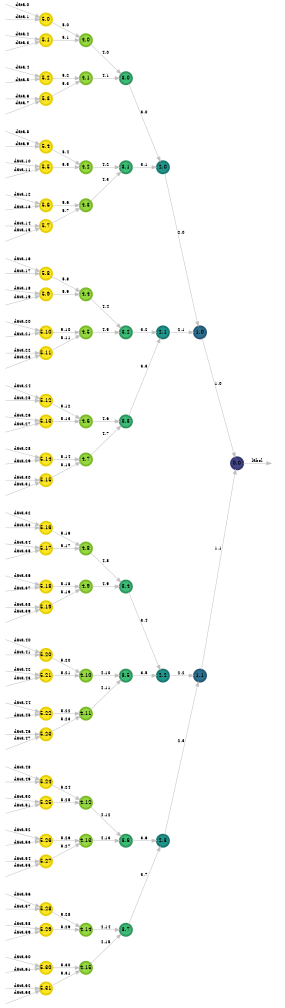

In [70]:
DEVICE = 'cuda'
BOND_DIM = 10
DTYPE = torch.double
features = h**2

model = TTNModel(features, bond_dim=BOND_DIM, device=DEVICE, dtype=DTYPE)
model.draw()

In [71]:
model.initialize(train_dl, loss)
pre_trained = model.tensors[0].data.clone()
pre_trained

tensor([[[0.2202, 0.4727],
         [0.8808, 0.1588],
         [0.0745, 0.4466],
         [0.9636, 0.4680],
         [0.1821, 0.6686],
         [0.0318, 0.1000],
         [0.5667, 0.5634],
         [0.6643, 0.8124],
         [0.9642, 0.7931],
         [0.9837, 0.4014]],

        [[0.4834, 0.6245],
         [0.9872, 0.2572],
         [0.3340, 0.1027],
         [0.0350, 0.9091],
         [0.5679, 0.2938],
         [0.1350, 0.2842],
         [0.0934, 0.1906],
         [0.5438, 0.6816],
         [0.7527, 0.7822],
         [0.3672, 0.3505]],

        [[0.4182, 0.8884],
         [0.1017, 0.7473],
         [0.6954, 0.6891],
         [0.3524, 0.2758],
         [0.7702, 0.7677],
         [0.7255, 0.6756],
         [0.8472, 0.5812],
         [0.0593, 0.4308],
         [0.3262, 0.4166],
         [0.4093, 0.8235]],

        [[0.3091, 0.3742],
         [0.4054, 0.7241],
         [0.1145, 0.7157],
         [0.5014, 0.7540],
         [0.2682, 0.0381],
         [0.2090, 0.0681],
         [0.0578, 0.90

In [41]:
data = torch.rand(features, 256, 2, dtype=torch.cdouble, device=DEVICE)
with torch.no_grad():
    result = timeit(lambda: model(data), number=1000)
result

4.380039863001002

In [72]:

def train_one_epoch(model, device, train_dl, loss_fn, optimizer):
    running_loss = 0.
    last_loss = 0.
    last_batch = 0
    loss_history = []

    pbar = tqdm(enumerate(train_dl), total=len(train_dl),position=0)
    for i, data in enumerate(train_dl):

        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.squeeze().to(device, dtype=DTYPE, non_blocking=True), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        probs = torch.pow(outputs, 2)
        if DTYPE == torch.cdouble:
            probs = torch.real(probs)

        probs = probs / torch.sum(probs)

        # Compute the loss and its gradients
        loss = loss_fn(labels, probs)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        loss_history.append(loss.item())
        if i % 10 == 9:
            last_batch = i+1
            last_loss = running_loss / 10 # mean loss over 10 batches
            running_loss = 0.  
        pbar.update()
        pbar.set_postfix({'current loss': loss.item(), 
                          f'batches {last_batch-10}-{last_batch} loss': last_loss, 
                          'weight_norm': torch.as_tensor([torch.norm(tensor) for tensor in model.tensors]).mean(0).item()})
        
    pbar.set_postfix({'current loss': loss.item(), f'batches {last_batch-10}-{last_batch} loss': last_loss, 'epoch mean loss': np.array(loss_history).mean()}) # not correct as the last batch is averaged on less samples
    pbar.close()
    return loss_history


In [73]:
LR = 1e-1
EPOCHS = 25
SCHEDULER_STEPS = 20


model.train()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1, verbose=False), torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)]
scheduler = schedulers[0]

In [74]:

tot_loss_history = []
now = datetime.now()
for epoch in trange(EPOCHS, desc='epochs', position=0):
    loss_history = train_one_epoch(model, DEVICE, train_dl, loss, optimizer)
    tot_loss_history += loss_history
    scheduler.step()
    
loss_history = np.array(tot_loss_history)

epochs: 100%|██████████| 25/25 [04:07<00:00,  9.88s/it]


In [75]:
post_trained = model.tensors[0].data.clone()
post_trained

tensor([[[ 2.4654e-03,  3.9018e-02],
         [-1.9053e-02, -4.6577e-02],
         [-1.1197e-02,  4.3605e-03],
         [ 4.3602e-03, -2.1230e-02],
         [ 1.5155e-02,  3.9639e-03],
         [-4.3164e-11,  1.1124e-11],
         [ 1.4671e-02,  8.6886e-03],
         [ 1.0070e-14,  2.1878e-14],
         [-1.2451e-04, -5.2255e-04],
         [-1.8389e-13, -1.0568e-13]],

        [[-6.5076e-03, -2.9218e-02],
         [-1.1489e-02, -1.7583e-02],
         [ 3.3832e-05, -3.2099e-04],
         [-3.5927e-04,  8.4601e-03],
         [-6.4249e-04,  7.1835e-04],
         [-2.7428e-11,  1.9727e-10],
         [-1.5010e-04,  4.5514e-03],
         [ 3.2409e-13,  5.2935e-12],
         [-2.6158e-05, -3.7932e-04],
         [ 1.0850e-14,  8.2413e-14]],

        [[ 1.2598e-02,  2.1305e-02],
         [-7.5511e-03, -4.5247e-02],
         [-4.4090e-03,  7.0137e-04],
         [ 1.2162e-03, -5.8821e-03],
         [ 5.9771e-03,  4.0874e-03],
         [-1.6877e-11, -7.0210e-13],
         [ 6.4362e-03,  8.9699e-03

In [76]:
accuracy(model, DEVICE, train_dl, test_dl, DTYPE)

test:   0%|          | 0/62 [00:00<?, ?it/s]

train:   0%|          | 0/371 [00:00<?, ?it/s]

(0.5, 0.5)

In [17]:
torch.save(model.state_dict, f'models/trainedmodel_{str(DTYPE).split(".")[1]}{now.strftime("%Y%m%d-%H%M%S")}.dict')
np.save(f'models/loss_history_{now.strftime("%Y%m%d-%H%M%S")}.npy', loss_history)

0.4646147693112691


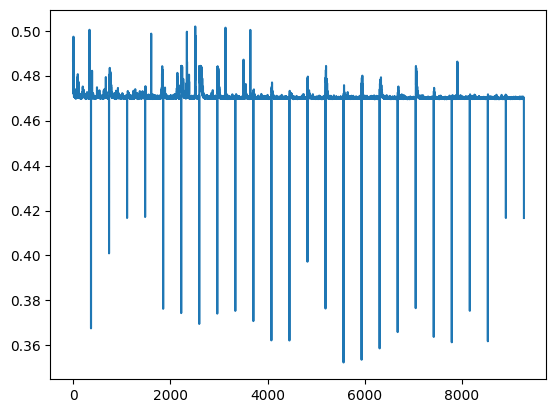

In [78]:
plt.plot(range(len(loss_history)), loss_history)
#plt.ylim(0, 2)
print(np.mean(loss_history[-10:]))

Text(0.5, 1.0, 'Training Loss')

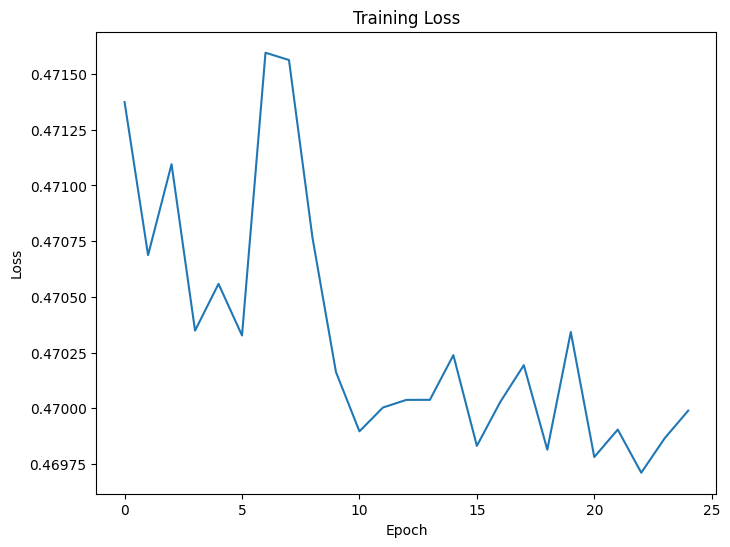

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot([loss_history[i*len(train_dl):((i+1)*len(train_dl) if i<EPOCHS-1 else -1)].mean() for i in range(EPOCHS)])

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')

#fig.savefig(f'models/loss_history_{now.strftime("%Y%m%d-%H%M%S")}.png')